<a href="https://colab.research.google.com/github/johnGachihi/linear-regression-with-generalization/blob/master/PCA_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from matplotlib import cm
from math import sqrt

data = pd.read_csv("train_data.csv")

# i. Handling of missing values

 - For the features in the array below, NA values were filled with a value '\_none\_' because the data description stated that in these columns NA meant an absence of the object the feature is about. We therefore considered it as one of the possible values for these features.

In [0]:
feats_to_fill = ["Alley", "BsmtQual", "BsmtCond", "BsmtFinType1",
                 "FireplaceQu", "GarageType", "GarageFinish",
                 "GarageQual", "GarageCond", "PoolQC", "Fence",
                 "MiscFeature", "MasVnrType", "BsmtExposure",
                 "BsmtFinType2"]
data.loc[:, feats_to_fill] = data.loc[:, feats_to_fill].fillna("_none_")

- For non-categorical features with NA values, the NA values were imputed using the mean.

In [0]:
non_categorical_feats_with_NAs = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
imputer = SimpleImputer()
for feat in non_categorical_feats_with_NAs:
  data[feat] = imputer.fit_transform(data[feat].values.reshape(-1, 1))


- For the `Electrical` feature which had a single NA value, we imputed the NA value using `most_frequent` strategy. We felt that this would not affect accuracy of the data too much because the most frequently occuring value for this feature comprised about 90% of the data in the column



In [0]:
imputer = SimpleImputer(strategy="most_frequent")
data["Electrical"] = imputer.fit_transform(data["Electrical"].values.reshape(-1, 1))

# Encoding the data
We encoded the ordinal features using Label Encoding but we ordered the labels according to the magnitude of each values of the feature (as shown in the dataset). E.g. For ExterQual (Exterior Quality) feature:
```
1 -> Poor, 2 -> Fair, 3 -> Average, 4 -> Good, 5 -> Excelent
```

In [0]:
def ordinal_encode(data, feats, categories):
  codes = ordinal_codes(categories)
  if type(feats) == list:
    for feat in feats:
      data[feat] = data[feat].map(codes)
  elif type(feats) == str:
    data[feats] = data[feats].map(codes)
  else:
    raise Exception("Invalid feat argument")

def ordinal_codes(list):
  return {v: i for i, v in enumerate(list, start=1)}


conditions = ['_none_', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
condition_feats = ["ExterQual", "ExterCond", "BsmtQual",
                   "BsmtCond", "HeatingQC", "KitchenQual",
                   "FireplaceQu", "GarageCond", "GarageQual",
                   "PoolQC"]
ordinal_encode(data, condition_feats, conditions)

ordinal_encode(
    data,
    "LotShape",
    ["IR3", "IR2", "IR1", "Reg"]
)
ordinal_encode(
    data,
    "LandSlope",
    ["Sev", "Mod", "Gtl"]
)
ordinal_encode(
    data,
    ["BsmtExposure"],
    ["_none_", "No", "Mn", "Av", "Gd"]
)
ordinal_encode(
    data,
    ["BsmtFinType1", "BsmtFinType2"],
    ["_none_", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
)
ordinal_encode(
    data,
    ["Functional"],
    ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"]
)
ordinal_encode(
    data,
    ["GarageFinish"],
    ["_none_", "Unf", "RFn", "Fin"]
)
ordinal_encode(
    data,
    ["PavedDrive"],
    ["N", "P", "Y"]
)
ordinal_encode(
    data,
    ["Fence"],
    ["_none_", "MnWw", "GdWo", "MnPrv", "GdPrv"]
)


We then encoded nominal features using one-hot encoding.

In [0]:
encoded_nominal_data = pd.get_dummies(data.select_dtypes(include="object"))
nominal_feats = data.select_dtypes(include="object").columns
data.drop(nominal_feats, axis=1, inplace=True)
data = pd.concat([encoded_nominal_data, data], axis=1)

# ii. Use PCA to filter out two Principle Components

In [0]:
X = StandardScaler().fit_transform(data.drop("SalePrice", axis=1))

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)
pca_data = pd.DataFrame(pca_components, columns = ['PC1', "PC2"])


# iii. Determine the percentage of information carried by the above 2 Principal
Component
We determined the percentage of the information carried by the two components to be `10.23%` as printed by the code below.

In [541]:
exp_var = round(sum(pca.explained_variance_ratio_)*100, 4)
print(f"Percentage info carried by first two PCs: {exp_var}%")

Percentage info carried by first two PCs: 10.2322%


# iv. If we were to capture 90% variance, how many PCs will be needed? Provide code line.
We found that `124` PCs are needed to capture 90% variance

In [542]:
temp_pca = PCA(n_components=0.9, svd_solver="full")
pca_components = temp_pca.fit_transform(X)
print(f"PCs required for 90% variance: {temp_pca.n_components_}")


PCs required for 90% variance: 124


Training the model

In [0]:
regressor = LassoCV(cv=5)
regressor.fit(pca_data, data["SalePrice"])
m1, m2 = regressor.coef_

# v. Plot a 3D plane of Best Fit

We got the coordinates for the plane from the points \\((x, y),\hspace{5pt} x \in PC1, y \in PC2\\), that were nearest the vertices of the x-y plane. Then using the trained model we predict the \\(\hat{z}\\) coordinate for these points.

__NB: ** I noticed the code below fails when run independently of the above code. Therefore, to run we were using <ins>Runtime</ins> > <ins>Run All</ins> (Ctrl + F9) to run all the code in all the code cells__

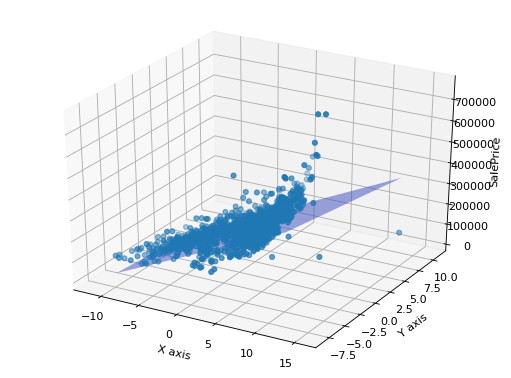

In [544]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
# ax = plt.axes(projection='3d')

pca_data = pd.concat([pca_data, data["SalePrice"]], axis=1)

x = pca_data.loc[:, 'PC1']
y = pca_data.loc[:, 'PC2']
z = pca_data["SalePrice"]
ax.scatter(x, y, z)

x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()
distances = []
for x, y in pca_data[["PC1", "PC2"]].values:
  distances.append([
    sqrt((x-x_min)**2 + (y-y_max)**2),
    sqrt((x-x_max)**2 + (y-y_max)**2),
    sqrt((x-x_min)**2 + (y-y_min)**2),
    sqrt((x-x_max)**2 + (y-y_min)**2)
  ])

pca_data = pd.concat([
    pca_data,
    pd.DataFrame(distances, columns=[
      "x_min__y_max",
      "x_max__y_max",
      "x_min__y_min",
      "x_max__y_min"
    ])
], axis=1)

x1, y1 = pca_data.loc[pca_data["x_min__y_max"].idxmin(), ["PC1", "PC2"] ]
x2, y2 = pca_data.loc[pca_data["x_max__y_max"].idxmin(), ["PC1", "PC2"] ]
x3, y3 = pca_data.loc[pca_data["x_min__y_min"].idxmin(), ["PC1", "PC2"] ]
x4, y4 = pca_data.loc[pca_data["x_max__y_min"].idxmin(), ["PC1", "PC2"] ]

z_h1, z_h2, z_h3, z_h4 = regressor.predict([[x1, y1],
                                            [x2, y2],
                                            [x3, y3],
                                            [x4, y4]])

ax.plot_surface(
    np.array([[x1,   x2],   [x3,   x4]]),
    np.array([[y1,   y2],   [y3,   y4]]),
    np.array([[z_h1, z_h2], [z_h3, z_h4]]),
    cmap=cm.coolwarm, alpha=0.5
)

ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("SalePrice")
plt.show()


# vi. Write down the general linear regression equation for this challenge using only two PCs

The Lasso linear model got the following as the general linear regression equation: \\[\hat{z} = 15694.4736x - 325.3958y + 180921.1958\\]

In [545]:
b = regressor.intercept_
print(f"z_hat = {round(m1, 4)}*x + {round(m2, 4)}*y + {b}")

z_hat = 15694.4791*x + -325.8469*y + 180921.19589041095
